In [1]:
from __future__ import print_function
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms 

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

                


In [3]:
train = datasets.MNIST("./data", train =True, download =True, transform= train_transforms)
test = datasets.MNIST("./data", train =False , download =True, transform= test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=8, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
dropout_value = 0.1
from model import Model_2
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_2().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9            [-1, 6, 24, 24]              60
        MaxPool2d-10            [-1, 6, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]             648
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

In [7]:
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [8]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss+=loss.item()
        
        loss.backward()
        optimizer.step()
        correct += GetCorrectPredCount(output, target)
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))
    
    print('\nTrain set: Train loss: {:.4f}, Train Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
model = Model_2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


loss=0.1297532469034195 batch_id=468: 100%|██████████████████████████████████████████| 469/469 [00:07<00:00, 59.13it/s]



Train set: Train loss: 217.5643, Train Accuracy: 52698/60000 (87.83%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0783, Accuracy: 9789/10000 (97.89%)

EPOCH: 1


loss=0.07226715236902237 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:07<00:00, 66.40it/s]



Train set: Train loss: 44.0540, Train Accuracy: 58415/60000 (97.36%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9868/10000 (98.68%)

EPOCH: 2


loss=0.07326216995716095 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:07<00:00, 66.28it/s]



Train set: Train loss: 34.8739, Train Accuracy: 58700/60000 (97.83%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9865/10000 (98.65%)

EPOCH: 3


loss=0.022393951192498207 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:07<00:00, 66.82it/s]



Train set: Train loss: 29.0936, Train Accuracy: 58887/60000 (98.14%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


loss=0.09861773252487183 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:07<00:00, 62.24it/s]



Train set: Train loss: 26.1654, Train Accuracy: 58992/60000 (98.32%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


loss=0.15446306765079498 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:07<00:00, 63.81it/s]



Train set: Train loss: 24.3396, Train Accuracy: 59022/60000 (98.37%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


loss=0.017239386215806007 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 67.13it/s]



Train set: Train loss: 22.2188, Train Accuracy: 59146/60000 (98.58%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9906/10000 (99.06%)

EPOCH: 7


loss=0.024457789957523346 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:07<00:00, 64.24it/s]



Train set: Train loss: 21.2659, Train Accuracy: 59148/60000 (98.58%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


loss=0.024833103641867638 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:07<00:00, 66.56it/s]



Train set: Train loss: 20.4594, Train Accuracy: 59176/60000 (98.63%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


loss=0.05031125620007515 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 67.48it/s]



Train set: Train loss: 19.6115, Train Accuracy: 59242/60000 (98.74%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


loss=0.051929403096437454 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:07<00:00, 65.70it/s]



Train set: Train loss: 18.3028, Train Accuracy: 59268/60000 (98.78%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


loss=0.043554674834012985 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:07<00:00, 65.63it/s]



Train set: Train loss: 18.2467, Train Accuracy: 59268/60000 (98.78%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


loss=0.07244827598333359 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 67.01it/s]



Train set: Train loss: 17.7385, Train Accuracy: 59287/60000 (98.81%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


loss=0.013470735400915146 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:07<00:00, 66.23it/s]



Train set: Train loss: 17.3438, Train Accuracy: 59297/60000 (98.83%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


loss=0.018463673070073128 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:07<00:00, 65.81it/s]



Train set: Train loss: 17.6226, Train Accuracy: 59289/60000 (98.81%)


Test set: Average loss: 0.0239, Accuracy: 9919/10000 (99.19%)



In [60]:
#t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

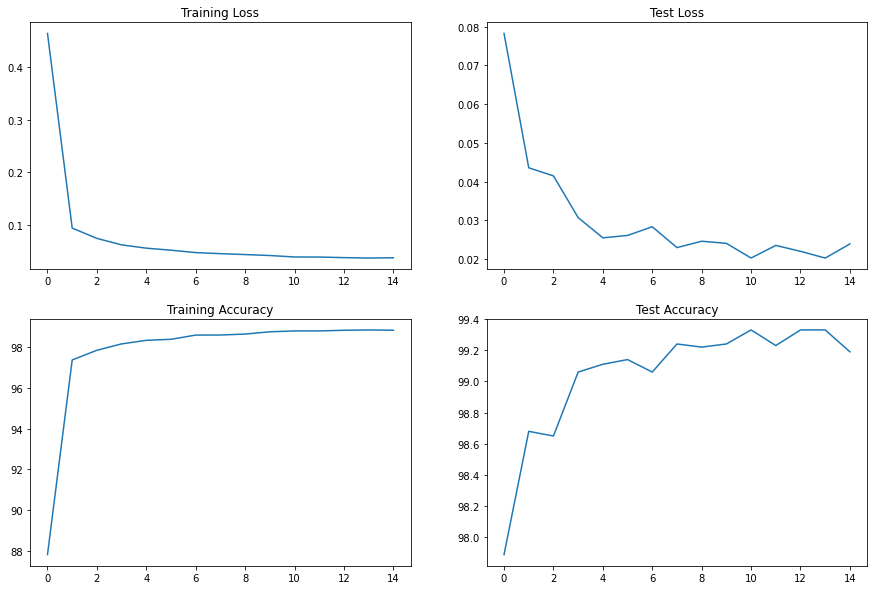

In [10]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")


Text(0.5, 1.0, 'Loss per epoch')

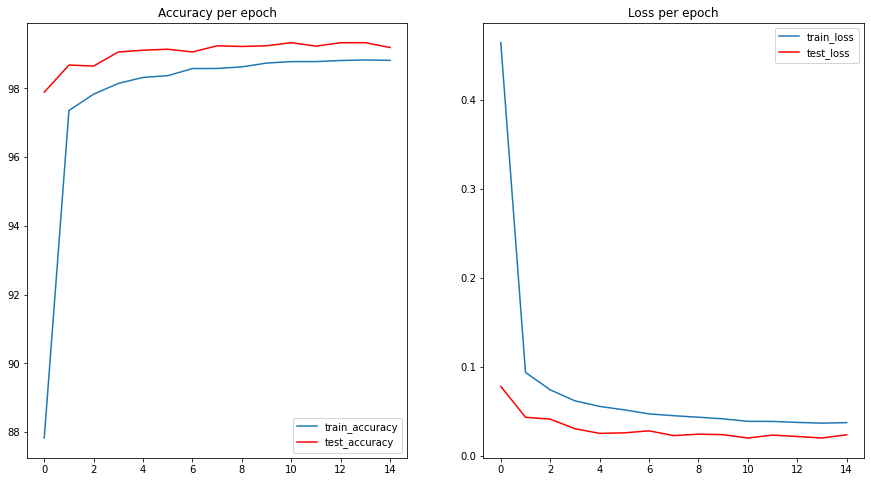

In [11]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

plt.subplot(1,2, 1)

plt.plot(np.array(train_acc))
plt.plot(np.array(test_acc), 'r')
plt.legend(["train_accuracy", "test_accuracy"])
plt.title("Accuracy per epoch")

plt.subplot(1,2,2)
plt.plot(train_losses)
plt.plot(test_losses, 'r')
plt.legend(["train_loss", "test_loss"])
plt.title("Loss per epoch")
     

## Inference 

### Target 
1. Get set up
   Get transforms, Data Loader, Basic Working codd, training and test lopp 
2. Results 
   Parameters : 8.3 k Parameters  
   Epoch 15 
   TRaining Acc: 98.81
   Test Acc: 99.19

3. Analysis 
   1. Training and Test accuracy become plateau  
   2. less overfit model 
   3. can training make fast 
   4. change the learning rate 
   